In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input

E0000 00:00:1748064633.870345      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748064633.927460      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = '/GPU' if tf.config.list_physical_devices('GPU') else '/CPU'
data_dir = '/kaggle/input/screws/augmented_dataset/screw'
batch_size = 32
num_epochs = 100
lr = 1e-3
img_size = 224

In [3]:
def load_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    label_map = {}
    for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        label_map[idx] = class_name
        for img_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(idx)
    return image_paths, labels, label_map

In [4]:

image_paths, labels, label_map = load_image_paths_and_labels(data_dir)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f"Total samples: {len(image_paths)}")
print(f"Train samples: {len(train_paths)} (~60%)")
print(f"Validation samples: {len(val_paths)} (~20%)")
print(f"Test samples: {len(test_paths)} (~20%)")
print("\n")

def count_samples_per_class(labels, label_map):
    class_counts = {}
    for idx, class_name in label_map.items():
        count = sum(1 for label in labels if label == idx)
        class_counts[class_name] = count
    return class_counts

total_counts = count_samples_per_class(labels, label_map)
train_counts = count_samples_per_class(train_labels, label_map)
val_counts = count_samples_per_class(val_labels, label_map)
test_counts = count_samples_per_class(test_labels, label_map)

class_totals = {class_name: train + val + test for class_name, train, val, test in 
                zip(sorted(label_map.values()), 
                    [train_counts.get(class_name, 0) for class_name in sorted(label_map.values())],
                    [val_counts.get(class_name, 0) for class_name in sorted(label_map.values())],
                    [test_counts.get(class_name, 0) for class_name in sorted(label_map.values())])}

total_images = sum(total_counts.values())

print("Thống kê số lượng ảnh trong mỗi class:")
print(f"{'Class':<20} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<15}")
print("-" * 75)

for class_name in sorted(label_map.values()):
    total = total_counts[class_name]
    train = train_counts.get(class_name, 0)
    val = val_counts.get(class_name, 0)
    test = test_counts.get(class_name, 0)
    class_total = class_totals[class_name]
    print(f"{class_name:<20} {train:<10} {val:<10} {test:<10} {class_total:<15}")

total_all = sum(total_counts.values())
train_all = sum(train_counts.values())
val_all = sum(val_counts.values())
test_all = sum(test_counts.values())
class_total_all = sum(class_totals.values())

print("-" * 75)
print(f"{'Total':<20} {train_all:<10} {val_all:<10} {test_all:<10} {class_total_all:<15}")

Total samples: 2872
Train samples: 1723 (~60%)
Validation samples: 574 (~20%)
Test samples: 575 (~20%)


Thống kê số lượng ảnh trong mỗi class:
Class                Train      Val        Test       Total          
---------------------------------------------------------------------------
good                 295        98         99         492            
manipulated_front    288        96         96         480            
scratch_head         288        96         96         480            
scratch_neck         300        100        100        500            
thread_side          276        92         92         460            
thread_top           276        92         92         460            
---------------------------------------------------------------------------
Total                1723       574        575        2872           


In [5]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = preprocess_input(img)  
    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = (train_dataset
                 .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = (val_dataset
               .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = (test_dataset
                .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

I0000 00:00:1748064645.899504      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_map), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/100


I0000 00:00:1748064665.772164      58 service.cc:148] XLA service 0x79e04414d880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748064665.773011      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748064667.649130      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/54 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0989 - loss: 1.8829

I0000 00:00:1748064676.219628      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - accuracy: 0.2775 - loss: 1.6951 - val_accuracy: 0.5610 - val_loss: 1.2746 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6268 - loss: 1.1587 - val_accuracy: 0.6934 - val_loss: 0.9354 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7259 - loss: 0.8780 - val_accuracy: 0.7666 - val_loss: 0.7464 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7718 - loss: 0.7220 - val_accuracy: 0.7857 - val_loss: 0.6352 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8140 - loss: 0.6194 - val_accuracy: 0.8101 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8501 - loss: 0.5153 - val_accuracy: 0.8031 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8400 - loss: 0.4893 - val_accura

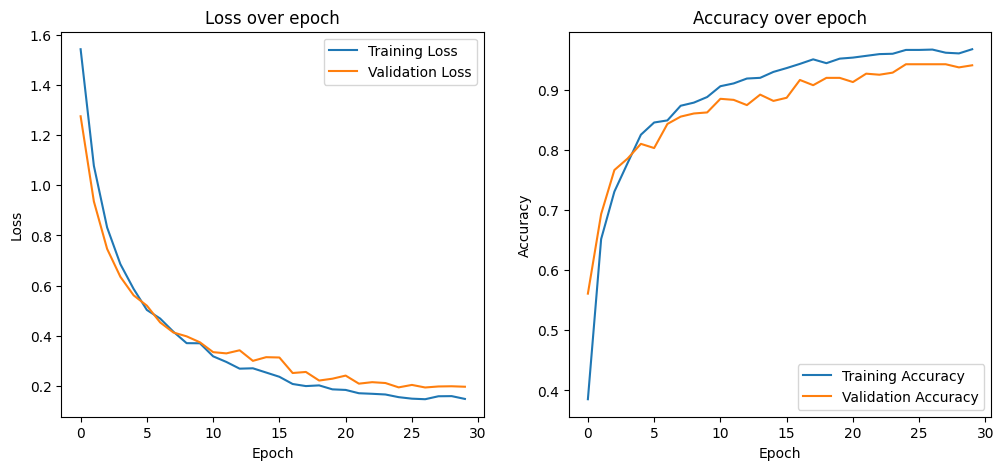

In [7]:
checkpoint_callback = ModelCheckpoint(
    '/kaggle/working/best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6,
    mode='min'
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    preds = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in sorted(label_map)]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Classification Report:
                   precision    recall  f1-score   support

             good       0.93      0.99      0.96        99
manipulated_front       0.97      0.97      0.97        96
     scratch_head       0.94      0.98      0.96        96
     scratch_neck       1.00      0.94      0.97       100


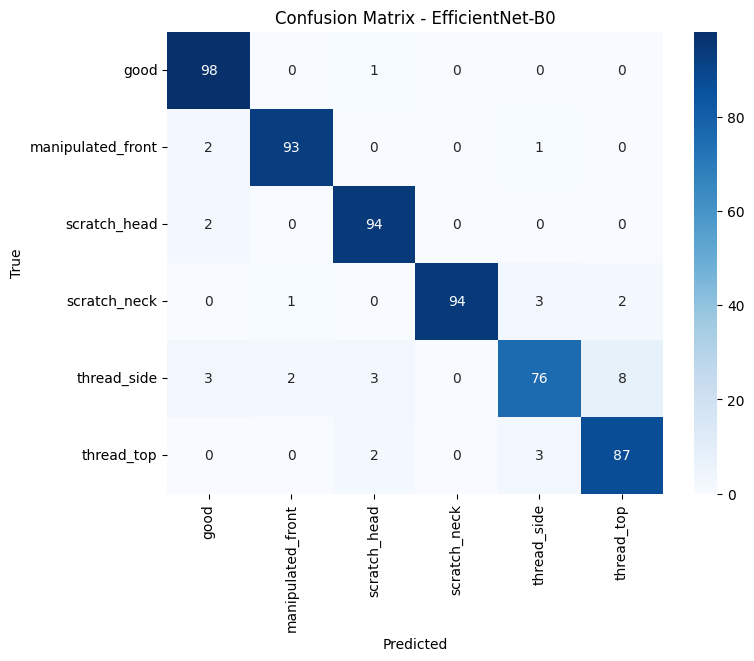

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[label_map[i] for i in sorted(label_map)],
    yticklabels=[label_map[i] for i in sorted(label_map)]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNet-B0")
plt.show()